# <img style="float: left; padding-right: 10px; width: 45px" src="https://github.com/Harvard-IACS/2018-CS109A/blob/master/content/styles/iacs.png?raw=true"> CS109A Introduction to Data Science 

## Lecture 3 (Pandas + Beautiful Soup)

**Harvard University**<br>
**Fall 2019**<br>
**Instructors:** Pavlos Protopapas, Kevin Rader, and Chris Tanner<br>
**Authors:** Rahul Dave, David Sondak, Will Claybaugh, Pavlos Protopapas, Chris Tanner

---

In [1]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING 
from IPython.core.display import HTML
from IPython.display import Image
def css_styling():
    styles = open("../../../styles/cs109.css", "r").read()
    return HTML(styles)
css_styling()

FileNotFoundError: [Errno 2] No such file or directory: '../../../styles/cs109.css'

# Table of Contents 
<ol start="0">
<li> Learning Goals </li>
<li> Loading and Cleaning with Pandas</li>
<li> Parsing and Completing the Dataframe  </li>
<li> Grouping </li>
</ol>

## Learning Goals

This Jupyter notebook accompanies Lecture 3. By the end of this lecture, you should be able to:

- Understand why and how Pandas can be useful.
- Use Pandas to:
    - Load data into a DataFrame
    - Access subsets of data based on column and row values
    - Address missing values (e.g., `NaN`)
    - Use `groupby()` to select sections of data.
    - Plot DataFrames (e.g., barplot())
- Use Beautiful Soup to download a webpage and all of its links

In [2]:
import pandas

## Part 1: Processing Data without Pandas 

`../data/top50.csv` is a dataset found online (Kaggle.com) that contains information about the 50 most popular songs on Spotify in 2019.

Each row represents a distinct song.
The columns (in order) are:
```
ID: a unique ID (i.e., 1-50)
TrackName: Name of the Track
ArtistName: Name of the Artist
Genre: the genre of the track
BeatsPerMinute: The tempo of the song.
Energy: The energy of a song - the higher the value, the more energetic. song
Danceability: The higher the value, the easier it is to dance to this song.
Loudness: The higher the value, the louder the song.
Liveness: The higher the value, the more likely the song is a live recording.
Valence: The higher the value, the more positive mood for the song.
Length: The duration of the song (in seconds).
Acousticness: The higher the value, the more acoustic the song is.
Speechiness: The higher the value, the more spoken words the song contains.
Popularity: The higher the value, the more popular the song is.
```

In [3]:
Image("fig/top50_screenshot.png") # sample of the data

FileNotFoundError: No such file or directory: 'fig/top50_screenshot.png'

FileNotFoundError: No such file or directory: 'fig/top50_screenshot.png'

<IPython.core.display.Image object>

### Read and store `../data/top50.csv`

**Q1:** Read in the `../data/top50.csv` file and store all of its contents into any data structure(s) that make the most sense to you, keeping in mind that you'd want to easily access any row or column. What data structure(s) make the most sense to use?

In [183]:
f = open("../data/top50.csv")
column_names = f.readline().strip().split(",")[1:] # puts names in a list
cleaned_column_names = [name for name in column_names] # removes the extraneous quotes
cleaned_column_names.insert(0, "ID")

dataset = []

# iterates through each line of the .csv file
for line in f:
    attributes = line.strip().split(",")
    
    # constructs a new dictionary for each line, and
    # appends this dictionary to the `dataset`;
    # thus, the dataset is a list of dictionaries (1 dictionary per song)
    dataset.append(dict(zip(cleaned_column_names, attributes)))

**Q2:** Write code to print all songs (Artist and Track name) that are longer than 4 minutes (240 seconds):

In [184]:
for song in dataset:
    if int(song["Length"]) > 240:
        print(song["ArtistName"], "-", song["TrackName"], "is", song["Length"],"seconds long")

Anuel AA - China is 302 seconds long
Bad Bunny - Callaita is 251 seconds long
Sech - Otro Trago - Remix is 288 seconds long
Chris Brown - No Guidance (feat. Drake) is 261 seconds long
J Balvin - LA CANCIÓN is 243 seconds long
Jhay Cortez - No Me Conoce - Remix is 309 seconds long
Lunay - Soltera - Remix is 266 seconds long


**Q3:** Write code to print the most popular song (or song(s) if there is a tie):

In [383]:
max_score = -1
most_populars = set()
for song in dataset:
    if int(song["Popularity"]) > max_score:
        most_populars = set([str(song["ArtistName"] + "-" + song["TrackName"])])
        max_score = int(song["Popularity"])
    elif int(song["Popularity"]) == max_score:
        most_populars.add(str(song["ArtistName"] + "-" + song["TrackName"]))
#print(most_populars)

**Q4:** Write code to print the songs (and their attributes), if we sorted by their popularity (highest scoring ones first).

In [186]:
# This gets tricky. How would you do it?

**Q5:** How could you check for null/empty entries? This is only 50 entries. Imagine if we had 500,000.

In [187]:
# you would need to iterate through every single value and check
# that's O(N*M), where N is the # of rows, and M is the # of columns.
# NOTE: what if you wished to impute any given non-value with the column's mean?
#       you would need another N checks

Often times, one dataset doesn't contain all of the information you are interested in -- in which case, you need to combine data from multiple files.

**Q6:** Imagine we had another table (i.e., .csv file) below. How could we combine its data with our already-existing *dataset*?

## Part 2: Processing Data _with_ Pandas 

**Pandas** is an _open-source_ Python library designed for **data analysis and processing.** Being _open-sourced_ means that anyone can contribute to it (don't worry, a team of people vett all official updates to the library). Pandas allows for high-performance, easy-to-use data structures. Namely, instead of using N-dimensional arrays like NumPy (which are extremely fast, though), Pandas provides a 2D-table object calleda **DataFrame**.

As a very gross simplification: **NumPy** is great for performing math operations with matrices, whereas **Pandas** is excellent for wrangling, processing, and understanding 2D data like spreadsheets (2D data like spreadsheets is very common and great).

Let's get started with simple examples of how to use Pandas. We will continue with our ``top50.csv`` Spotify music data.

First, we need to import pandas so that we have access to it. For typing convenience, we choose to rename it as ``pd``, which is common practice.

In [233]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

### Reading in the data
Pandas allows us to [read in various structured files](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html) (e.g., .csv, .json, .html, etc) with just one line:

In [382]:
# we don't always need to specify the encoding, but this particular
# file has special characters that we need to handle
top50 = pd.read_csv("../data/top50.csv")

### High-level view of the data

We can view the data frame by simply printing it:

In [381]:
#top50

Instead of printing the entire dataframe (e.g., ``print(top50)``), we can also inspect the file by looking at just the first N rows or last N rows.

In [380]:
#top50.head(3) # first 3 rows
#top50.tail(3)) # last 3 rows

That's cool, but we can't see all of the columns too well. To get a list of all columns:

In [379]:
#top50.columns

Remember, Pandas is in Python, so you can write regular Python code with it. For example, if you want to know how many columns there are, you can use Python's ``len()`` function.

In [378]:
#len(top50.columns)

Fortunately, many of the features in our dataset are numeric. Conveniently, Pandas' `describe()` function calculates basic statistics for our columns. It's pretty amazing, as it allows us a very coarse-grain approach to understanding our data and checking for errors. That is, if we notice any summary statistics that are drastically different than what we deem reasonable, we should dive deeper and figure out why the values are what they are.

In [377]:
#top50.describe()

Notice, it calculated statistics only for the columns that are of numeric data types. What about the textual ones (e.g., Track name and Artist)? Pandas is smart enough to infer the data types. **Don't forget to inspect the columns that are text-based though, as we need to ensure they are sound, too.**

To view the data type of each column:

In [376]:
#top50.dtypes

### Exploring the data

I agree with Pandas' handling of the data. If any column contained floating point numbers, we would expect to see such here, too.

Now that we've viewed our dataset at a high-level, let's actually use and explore it.

We can **access a column of data** the same way we access dictionary by its keys:

In [374]:
#top50["Length"]

We could have also used this syntax (identical results):

In [373]:
#top50.Length

If we want just the highest or lowest **value** of a given column, we can use the functions ``max()`` and ``min()``, respectively.

In [372]:
#top50['Length'].max()

In [371]:
#top50['Length'].min()

If we want the **row index** that corresponds to a column's max or min value, we can use ``idxmax()`` and ``idxmin()``, respectively.

In [370]:
#top50['Length'].idxmax()

In [369]:
#top50['Length'].idxmin()

We can also add `conditional statements` (e.g., >, <, ==) for columns, which yields a boolean vector:

In [368]:
#top50['Length'] > 240

This is useful, as it allows us to process only the rows with the True values.

The **`loc()`** function allows us to access data via labels:
- A single scalar label
- A list of labels
- A slice object
- A Boolean array

A single scalar:

In [367]:
# single scalar label
#top50.loc[0] # prints the (unnamed) row that has a label of 0 (the 1st row)

In [366]:
# list of labels
#top50.loc[[0,2]] # prints the (unnamed) rows that have the labels of 0 and 2 (the 1st and 3rd rows)

In [365]:
# a slice of the dataframe, based on the passed-in booleans;
# picture it's like a filter overlaying the DataFrame, and the filter
# dictates which values will be emitted/make it through to us

#top50.loc[top50['Length'] > 240] # prints all rows that have Length > 240

Note, this returns a *DataFrame*. Everything we've learned so far concerns how to use DataFrames, so we can tack on additional syntax to this command if we wish to do further processing.

For example, if we want to index just select columns (e.g., ArtistName, TrackName, and Length) of this returned DataFrame:

In [364]:
#top50.loc[top50['Length'] > 240][['ArtistName', 'TrackName', 'Length']]

Note, the above solves our original **Q2:** _(Write code to print all songs (Artist and Track name) that are longer than 4 minutes (240 seconds))_

**Q3:** Write code to print the most popular song (or song(s) if there is a tie):

In [309]:
## [TODO] TO BE FILLED IN DURING CLASS PARTICIPATION
# FEEL FREE TO WORK WITH A NEIGHBOR

We can also sort our data by a single column! This pertains to our original Q4!

**Q4:** Write code to print the songs (and their attributes), if we sorted by their popularity (highest scoring ones first).

In [314]:
#top50.sort_values("Popularity", ascending=False)

While ``.loc()`` allows us to index based on passed-in labels, ``.iloc()`` allows us to **access data based on 0-based indices.**

The syntax is ``.iloc[<row selection>, <column selection>]``, where <row selection> and <column selection> can be scalars, lists, or slices of indices.

In [363]:
#top50.iloc[5:6] # prints all columns for the 6th row

In [316]:
#top50.iloc[:,2] # prints all rows for the 3rd column

In [317]:
#top50.iloc[[0,2,3], [2,1]] # prints the 1st, 3rd, and 4th rows of the 3rd and 2nd columns (artist and track)

### Inspecting/cleaning the data

As mentioned, it is imperative to ensure the data is sound to use:
1. Did it come from a trustworthy, authoritative source?
2. Is the data a complete sample?
3. Does the data seem correct?
4. **(optional)** Is the data stored efficiently or does it have redundancies?

Let's walk through each of these points now:

1. Did it come from a trustworthy, authoritative source?

The data came from Kaggle.com, which anyone can publish to. However, the author claims that he/she used Spotify.com's official API to query songs in 2019. There are no public comments for it so far. It's potentially credible.

2. Is the data a complete sample?

Pandas has functions named ``isnull()`` and ``notnull()``, which return DataFrames corresponding to any null or non-null entries, respectively.

For example:

In [319]:
#top50[top50.ArtistName.isnull()] # returns an empty DataFrame

In [329]:
#top50[top50.ArtistName.notnull()] # returns the complete DataFrame since there are no null Artists

If we run this for all of our features/columns, we will see there are no nulls. Since this dataset is manageable in size, you can also just scroll through it and notice no nulls.

This answers our original Q5:

**Q5:** How could you check for null/empty entries?

Continuing with our data sanity check list:

3. Does the data seem correct?

A quick scroll through the data, and we see a song by _Maluma_ titled _0.95833333_. This is possibly a song about probability, but I think the chances are slim. The song is 176 seconds long (2m56s). Looking on Spotify, we see **Maluma's most popular song is currently _11PM_ which is 2m56s in length!** Somehow, during the creation of the dataset, 11PM became 0.95833333. _Bonus points if you can figure out where this pointing number could have come from._

In [362]:
#Image("fig/maluma.png") # sample of the data

Since only one song seems obviously wrong, we can manually fix it. And it's worth noting such to ourselves and to whomever else would see our results or receive a copy of our data. If there were many more wrong values, we'd potentialy not fix them, as we'd explore other options.

4. **(optional)** Is the data stored efficiently or does it have redundancies?

Everything seems fine. No repeated data.

### Combining multiple DataFrames

As mentioned, often times one dataset doesn't contain all of the information you are interested in -- in which case, you need to combine data from multiple files. This also means you need to verify the accuracy (per above) of each dataset.

Pandas' ``groupby()`` function splits the DataFrame into different groups, depending on the passed-in variable. For example, we can group our data by the genres:

In [360]:
grouped_df = top50.groupby('Genre')
#for key, item in grouped_df:
#    print("Genre:", key, "(", len(grouped_df.get_group(key)), "items):", grouped_df.get_group(key), "\n\n")

``../data/spotify_aux.csv`` contains the same 50 songs as ``top50.csv``; however, it only contains 3 columns:
- Track Name
- Artist Name
- Explicit Language (boolean valued)

Note, that 3rd column is just random values, but pretend as if it's correct. The point of this section is to demonstrate how to merge columns together.

Let's load ``../data/spotify_aux.csv`` into a DataFrame:

In [357]:
explicit_lyrics = pd.read_csv("../data/spotify_aux.csv")
#explicit_lyrics

Let's merge it with our ``top50`` DataFrame.

``.merge()`` is a Pandas function that stitches together DataFrames by their columns.

``.concat()`` is a Pandas function that stitches together DataFrames by their rows (if you pass axis=1 as a flag, it will be column-based)

In [356]:
# 'on='' specifies the column used as the shared key
df_combined = pd.merge(explicit_lyrics, top50, on='TrackName')
#df_combined

We see that all columns from both DataFrames have been added. That's nice, but having duplicate ArtistName and TrackName is unecessary. Since ``merge()`` uses DataFrames as the passed-in objects, we can simply pass merge() a stripped-down copy of _ExplicitLanguage_, which helps merge() not add any redundant fields. 

In [355]:
df_combined = pd.merge(explicit_lyrics[['TrackName', 'ExplicitLanguage']], top50, on='TrackName')
#df_combined

This answers our original Q6:

**Q6:** Imagine we had another table (i.e., .csv file) below. How could we combine its data with our already-existing *dataset*?


While we do not exhaustively illustrate Pandas' joining/splitting functionality, you may find the following functions useful:
- ``merge()``
- ``concat()``
- ``aggregate()``
- ``append()``

### Plotting DataFrames
As a very simple example of how one can plot elements of a DataFrame, we turn to Pandas' built-in plotting:

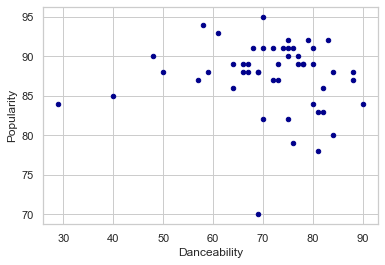

In [242]:
scatter_plot = top50.plot.scatter(x='Danceability', y='Popularity', c='DarkBlue')

This shows the lack of a correlation between the Danceability of a song and its popularity, based on just the top 50 songs, of course.

Please feel free to experiment with plotting other items of interest, and we recommend using Seaborn.

## Practice Problems with a Partner (or individually if you prefer)

**P1.** Print the shortest song (all features):

In [341]:
# [TODO] TO BE FILLED IN DURING CLASS PARTICIPATION

**P2.** Print the 5 shortest songs (all features):

In [334]:
# [TODO] TO BE FILLED IN DURING CLASS PARTICIPATION

**P3.** What is the average length of the 5 shortest songs?

In [343]:
# [TODO] TO BE FILLED IN DURING CLASS PARTICIPATION

**P4.** Write a function that accepts a DataFrame as an input and returns True if there exists any null values in the DataSet. Otherwise, returns False. Pass ``top50`` to the function in order to test it.

In [349]:
# [TODO] TO BE FILLED IN DURING CLASS PARTICIPATION

**P5.** How many distinct genres are present in the top 50 songs?

In [348]:
# [TODO] TO BE FILLED IN DURING CLASS PARTICIPATION

**P6.** Print the songs that have a Danceability score above 80 and a popularity above 86. HINT: you can combine conditional statements with the & operator, and each item must be surrounded with ( ) brackets.

In [347]:
# [TODO] TO BE FILLED IN DURING CLASS PARTICIPATION

**P7.** Print the songs that are faster than the average Top 50 and more popular than the average Top 50?

In [351]:
# [TODO] TO BE FILLED IN DURING CLASS PARTICIPATION

**P8.** Plot a histogram of the Genre counts (x-axis is the Genres, y-axis is the # of songs with that Genre)

In [353]:
# [TODO] TO BE FILLED IN DURING CLASS PARTICIPATION

**P9. (open ended)** Think of a _subset_ of the data that you're interested in. Think of an interesting plot that could be shown to illustrate that data. With a partner, discuss whose would be easier to create. Together, create that plot. Then, try to create the harder plot.

In [354]:
# [TODO] TO BE FILLED IN DURING CLASS PARTICIPATION